# Eager Execution: Working with Gradients

This notebook demonstrates:

* How to get gradients using TensorFlow's eager execution capabilities
* How to apply the gradients so you can update your variables

# Setup: Import eager and enable eager execution.


In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# Import TensorFlow.
import tensorflow as tf

# Import TensorFlow eager execution support (subject to future changes).
import tensorflow.contrib.eager as tfe

# Enable eager execution.
tfe.enable_eager_execution()

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


# Fitting a Simple Linear Model

## Step 1: Synthesize some data

To demonstrate fitting a model with TensorFlow's eager execution, we'll fit a linear model to some synthesized data (which includes some noise).

In the code, we  use the variable names `w` and `b` to represent the single weight and bias we'll use to fit our model.

In [3]:
import numpy as np


# The constants we'll try to fit our variables to:
true_w = 3
true_b = 2

NUM_EXAMPLES = 1000000  # 1000

# Our inputs:
inputs = np.random.normal(size=(NUM_EXAMPLES, 1))  # tf.random_normal(shape=[NUM_EXAMPLES, 1])

# Our labels, with noise:
noise = np.random.normal(size=(NUM_EXAMPLES, 1))  # tf.random_normal(shape=[NUM_EXAMPLES, 1])
labels = inputs * true_w + true_b + noise

# convert numpy arrays to Tensors
X = tf.constant(inputs, dtype="float32")
y_true = tf.constant(labels, dtype="float32")

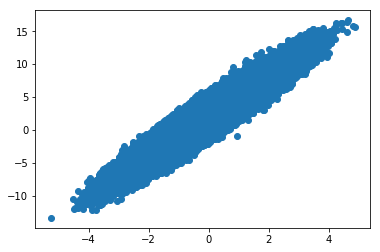

In [4]:
# Plot the Data (Optional)

import matplotlib.pyplot as plt

plt.scatter(inputs,  # .numpy(), 
            labels  # .numpy()
           )
plt.show()

## Step 2: Define our TensorFlow variables

We'll use Keras's object-oriented [`Dense`](https://www.tensorflow.org/api_docs/python/tf/contrib/keras/layers/Dense) layer to create our variables. In this case, we'll create a `Dense` layer with a single weight and bias.

(**Note**: We're using the implementation of `Dense` found in `tf.layers.Dense` though the documentation link is for `tf.contrib.keras.layers.Dense`. When TensorFlow 1.4 is released, the documentation will also be in `tf.layers.Dense`) 

In [5]:
# Create TensorFlow Variables using Keras's Dense layer.

wb = tf.layers.Dense(units=1, use_bias=True)

# We can access the underlying TensorFlow variables using wb.variables.
# However, the variables won't exist until the dimensions of the input
# tensors are known. Once the dimensions of the input tensors are known,
# Keras can create and initialize the variables. Until then, Keras will
# report the variables as an empty list: [].

wb.variables

[]

## Step 3: Define our loss function

Our loss function is the standard L2 loss (where we reduce the loss to its mean across its inputs).

In [6]:
def loss_fn(inputs, labels, wb):
  """Calculates the mean L2 loss for our linear model."""
  predictions = wb(inputs)
  return tf.reduce_mean(tf.square(predictions - labels))

In [7]:
# Test loss function (optional).

loss_fn(X, y_true, wb)

<tf.Tensor: id=34, shape=(), dtype=float32, numpy=20.407852>

In [8]:
# At this point, the variables exist, and can now be queried:

w, b = wb.variables
print("w: " + str(w.read_value()))
print("b: " + str(b.read_value()))

w: tf.Tensor([[-0.9167711]], shape=(1, 1), dtype=float32)
b: tf.Tensor([0.], shape=(1,), dtype=float32)


## Step 4: Create our gradients function using `implicit_value_and_gradients()`

With a loss function defined, we can calculate gradients and apply them to our variables to update them.

To calculate the gradients, we wrap our loss function using the `implicit_value_and_gradients()` function.

`implicit_value_and_gradients()` returns a function that accepts the same inputs as the function passed in, and returns a tuple consisting of:

1. the value returned by the function passed in (in this case, the loss calculated by `loss_fn()`), and
1. a list of tuples consisting of:
  1. The value of the gradient (a `tf.Tensor`) with respect to a given variable
  1. The corresponding variable (`tf.Variable`)

Test it out below to get a feel for what it does. Notice how the first value of the returned tuple (the loss) is the same as the value returned in the cell above that tests our loss function.

In [9]:
# Produce our gradients function. See description above for details about
# the returned function's signature.

value_and_gradients_fn = tfe.implicit_value_and_gradients(loss_fn)

In [10]:
print("Outputs of value_and_gradients_fn:")
value, grads_and_vars = value_and_gradients_fn(X,  # inputs, 
                                               y_true,  # labels, 
                                               wb)

print('Loss: {}'.format(value))
for (grad, var) in grads_and_vars:
  print("")
  print('Gradient: {}\nVariable: {}'.format(grad, var))

Outputs of value_and_gradients_fn:
Loss: 20.407852172851562

Gradient: [[-7.869093]]
Variable: <tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.9167711]], dtype=float32)>

Gradient: [-3.999566]
Variable: <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


## Step 5: Create an optimizer

We'll use a `GradientDescentOptimizer` to fit our model.

In [11]:
learning_rate = 1e-3
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

### Step 5a: Test Our Optimizer

Now we have everything needed to start fitting our variables to the data!

In the next cell, we'll demo these capabilities. We'll:

1. Print the current values of `w` and `b`
1. Calculate the loss and gradients
1. Apply the gradients
1. Print out the new values of `w` and `b`

You can run the cell multiple times. Each time, you should see the values of `w` and `b` get closer to their true values of 3 and 2.

In [12]:
# Test the optimizer.

print("Values of w, b, BEFORE applying gradients:")
w, b = wb.variables
print(w.read_value().numpy(), b.read_value().numpy())
print()

# Calculate the gradients:
empirical_loss, gradients_and_variables = value_and_gradients_fn(X,  # inputs, 
                                                                 y_true,  # labels, 
                                                                 wb)
optimizer.apply_gradients(gradients_and_variables)

print("Values of w, b, AFTER applying gradients:")
print(w.read_value().numpy(), b.read_value().numpy())

Values of w, b, BEFORE applying gradients:
[[-0.9167711]] [0.]

Values of w, b, AFTER applying gradients:
[[-0.90890205]] [0.00399957]


## Step 6: Create a training loop

Of course, now we can simply turn all of this code into a self-standing training loop. We'll also capture our loss and approximations of `w` and `b` and plot them over time.

In [13]:
num_training_steps = 1000  # 10

loss_at_step = []
w_at_step = []
b_at_step = []

In [14]:
%%time

for step_num in range(num_training_steps):
    loss, gradients_and_variables = value_and_gradients_fn(X,  # inputs, 
                                                           y_true,  # labels, 
                                                           wb)
    loss_at_step.append(np.asscalar(loss.numpy()))
    
    optimizer.apply_gradients(gradients_and_variables)
    w, b = wb.variables
    w_at_step.append(np.asscalar(w.read_value().numpy()))
    b_at_step.append(np.asscalar(b.read_value().numpy()))

CPU times: user 2min 47s, sys: 5.56 s, total: 2min 52s
Wall time: 16.3 s


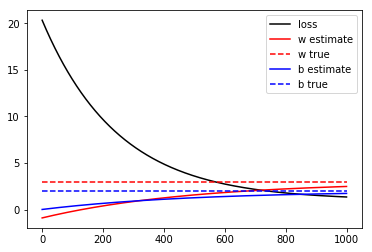

In [15]:
# print(w_at_step)
t = range(0, num_training_steps)
plt.plot(t, loss_at_step, 'k',
       t, w_at_step, 'r',
       t, [true_w] * num_training_steps, 'r--',
       t, b_at_step, 'b',
       t, [true_b] * num_training_steps, 'b--')
plt.legend(['loss', 'w estimate', 'w true', 'b estimate', 'b true'])
plt.show()